In [1]:
import pandas as pd
import numpy as np
import nltk
import spacy
import re
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from wordcloud import WordCloud
from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

In [3]:
# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [5]:
# Load the dataset
news = pd.read_excel("data_news.xlsx")

In [7]:
# Display basic information
print("Dataset Info:")
news.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   category           50000 non-null  object
 1   headline           50000 non-null  object
 2   links              50000 non-null  object
 3   short_description  49994 non-null  object
 4   keywords           47294 non-null  object
dtypes: object(5)
memory usage: 1.9+ MB


In [9]:
# Display first few rows
print("\nFirst few rows:")
print(news.head())


First few rows:
   category                                           headline  \
0  WELLNESS              143 Miles in 35 Days: Lessons Learned   
1  WELLNESS       Talking to Yourself: Crazy or Crazy Helpful?   
2  WELLNESS  Crenezumab: Trial Will Gauge Whether Alzheimer...   
3  WELLNESS                     Oh, What a Difference She Made   
4  WELLNESS                                   Green Superfoods   

                                               links  \
0  https://www.huffingtonpost.com/entry/running-l...   
1  https://www.huffingtonpost.com/entry/talking-t...   
2  https://www.huffingtonpost.com/entry/crenezuma...   
3  https://www.huffingtonpost.com/entry/meaningfu...   
4  https://www.huffingtonpost.com/entry/green-sup...   

                                   short_description  \
0  Resting is part of training. I've confirmed wh...   
1  Think of talking to yourself as a tool to coac...   
2  The clock is ticking for the United States to ...   
3  If you want to be busy

In [11]:
# Handle missing values
news = news.dropna(subset=['short_description']).copy()
news.loc[:, 'keywords'] = news['keywords'].fillna("")

In [13]:
# Ensure all text columns are strings before concatenation
news['text'] = news['headline'].astype(str) + " " + news['short_description'].astype(str) + " " + news['keywords'].astype(str)

In [15]:
# Text preprocessing function
nlp = spacy.load("en_core_web_sm")

In [17]:
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z ]', '', text)  # Remove special characters
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.text not in stopwords.words('english') and not token.is_punct]
    return " ".join(tokens)

In [19]:
# Apply preprocessing with progress bar
news['cleaned_text'] = [preprocess_text(text) for text in tqdm(news['text'], desc="Processing Text")]

Processing Text: 100%|███████████████████████████████████████████████████████████| 49994/49994 [17:23<00:00, 47.90it/s]


In [21]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(news['cleaned_text'], news['category'], test_size=0.2, random_state=42)

In [23]:
# Feature Extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [25]:
# Feature Extraction using Bag of Words
count_vectorizer = CountVectorizer(max_features=5000)
X_train_bow = count_vectorizer.fit_transform(X_train)
X_test_bow = count_vectorizer.transform(X_test)

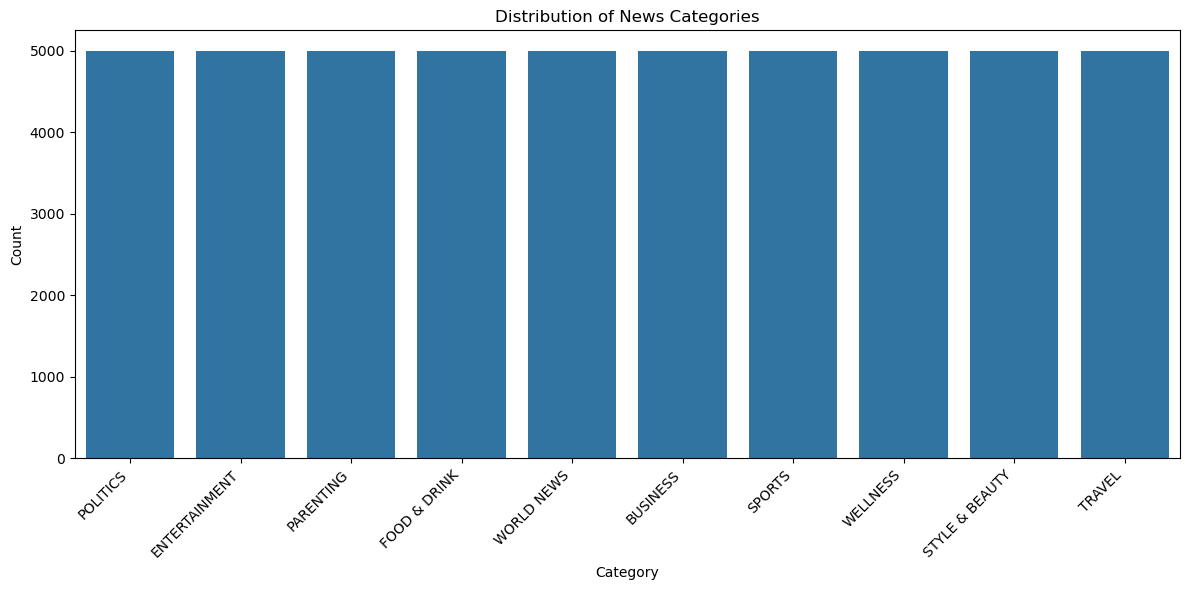

In [27]:
# Exploratory Data Analysis (EDA) - Improved Visualization
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=news, x='category', order=news['category'].value_counts().index)
plt.xticks(rotation=45, ha='right')  # Rotate labels for better readability
plt.title("Distribution of News Categories")
plt.xlabel("Category")
plt.ylabel("Count")

# Adjust x-axis labels to avoid overlap
plt.tight_layout()
plt.show()

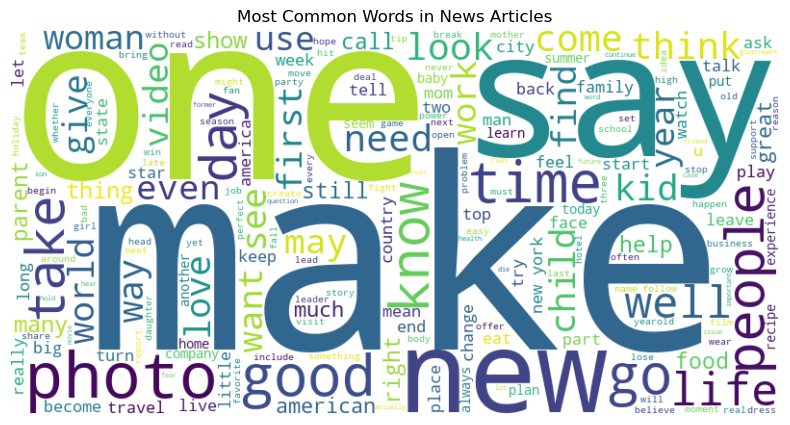

In [29]:
# Word Cloud for Most Common Words in News Articles
all_text = " ".join(news['cleaned_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Common Words in News Articles")
plt.show()

In [31]:
# Model Training and Evaluation
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "SVM": SVC(kernel='linear', probability=True)
}

results = {}

for name, model in tqdm(models.items(), desc="Training Models"):
    print(f"Training {name}...")
    model.fit(X_train_tfidf, y_train)
    predictions = model.predict(X_test_tfidf)
    accuracy = accuracy_score(y_test, predictions)
    results[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")
    print(classification_report(y_test, predictions))

Training Models:   0%|                                                                           | 0/3 [00:00<?, ?it/s]

Training Logistic Regression...


Training Models:  33%|██████████████████████▎                                            | 1/3 [00:01<00:03,  1.62s/it]

Logistic Regression Accuracy: 0.7954
                precision    recall  f1-score   support

      BUSINESS       0.73      0.78      0.75       947
 ENTERTAINMENT       0.76      0.77      0.77       972
  FOOD & DRINK       0.85      0.85      0.85      1013
     PARENTING       0.77      0.76      0.77       998
      POLITICS       0.81      0.73      0.77      1032
        SPORTS       0.88      0.89      0.88      1006
STYLE & BEAUTY       0.86      0.84      0.85       993
        TRAVEL       0.79      0.79      0.79      1027
      WELLNESS       0.70      0.74      0.72      1007
    WORLD NEWS       0.80      0.80      0.80      1004

      accuracy                           0.80      9999
     macro avg       0.80      0.80      0.80      9999
  weighted avg       0.80      0.80      0.80      9999

Training Naive Bayes...


Training Models:  67%|████████████████████████████████████████████▋                      | 2/3 [00:01<00:00,  1.24it/s]

Naive Bayes Accuracy: 0.7741
                precision    recall  f1-score   support

      BUSINESS       0.72      0.71      0.71       947
 ENTERTAINMENT       0.77      0.76      0.76       972
  FOOD & DRINK       0.83      0.86      0.84      1013
     PARENTING       0.66      0.74      0.70       998
      POLITICS       0.80      0.71      0.75      1032
        SPORTS       0.88      0.84      0.86      1006
STYLE & BEAUTY       0.84      0.80      0.82       993
        TRAVEL       0.78      0.80      0.79      1027
      WELLNESS       0.69      0.73      0.71      1007
    WORLD NEWS       0.79      0.80      0.79      1004

      accuracy                           0.77      9999
     macro avg       0.78      0.77      0.77      9999
  weighted avg       0.78      0.77      0.77      9999

Training SVM...


Training Models: 100%|██████████████████████████████████████████████████████████████████| 3/3 [09:41<00:00, 193.67s/it]

SVM Accuracy: 0.7922
                precision    recall  f1-score   support

      BUSINESS       0.72      0.81      0.76       947
 ENTERTAINMENT       0.73      0.76      0.74       972
  FOOD & DRINK       0.84      0.85      0.85      1013
     PARENTING       0.76      0.76      0.76       998
      POLITICS       0.81      0.72      0.76      1032
        SPORTS       0.88      0.90      0.89      1006
STYLE & BEAUTY       0.87      0.83      0.85       993
        TRAVEL       0.81      0.78      0.79      1027
      WELLNESS       0.71      0.73      0.72      1007
    WORLD NEWS       0.81      0.78      0.80      1004

      accuracy                           0.79      9999
     macro avg       0.79      0.79      0.79      9999
  weighted avg       0.79      0.79      0.79      9999



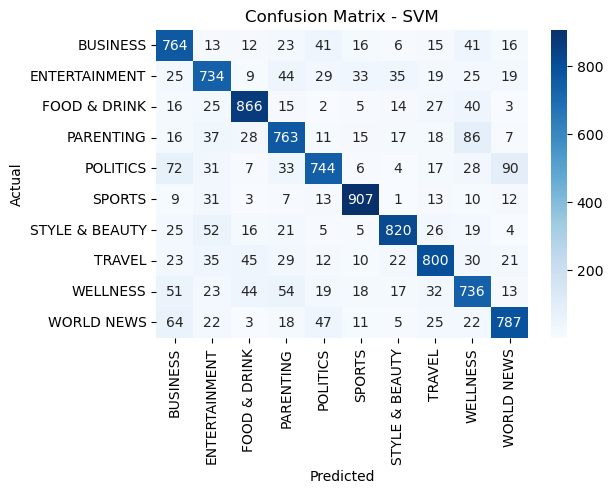

In [51]:
    # Confusion Matrix
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()

    print("\n")


In [53]:
# Optimized Cross-validation with parallel processing
for name, model in tqdm(models.items(), desc="Cross-Validation"):
    scores = cross_val_score(model, X_train_tfidf, y_train, cv=3, scoring='accuracy', n_jobs=-1)
    print(f"{name} Cross-Validation Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")


Cross-Validation:  33%|██████████████████████                                            | 1/3 [00:04<00:08,  4.50s/it]

Logistic Regression Cross-Validation Accuracy: 0.7895 (+/- 0.0014)


Cross-Validation:  67%|████████████████████████████████████████████                      | 2/3 [00:06<00:02,  2.78s/it]

Naive Bayes Cross-Validation Accuracy: 0.7826 (+/- 0.0009)


Cross-Validation: 100%|█████████████████████████████████████████████████████████████████| 3/3 [06:56<00:00, 138.88s/it]

SVM Cross-Validation Accuracy: 0.7845 (+/- 0.0020)


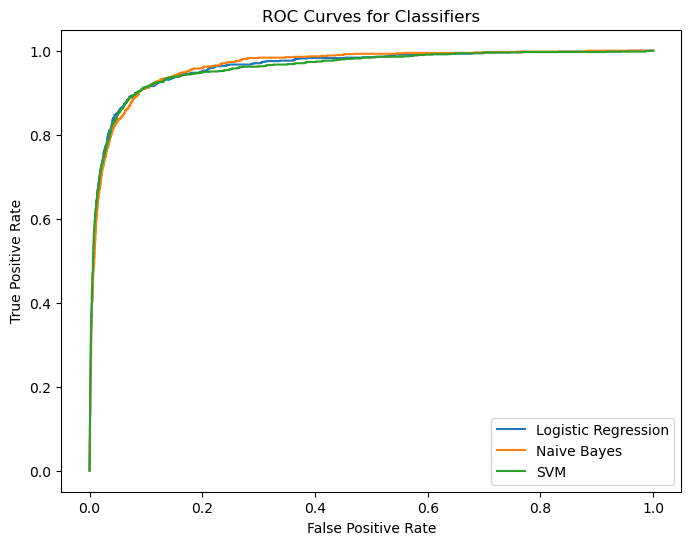

In [55]:
# ROC-AUC Scores
plt.figure(figsize=(8, 6))
for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test_tfidf)[:, 1]  # Take the probability of the positive class
        fpr, tpr, _ = roc_curve(y_test, y_proba, pos_label=np.unique(y_test)[1])
        plt.plot(fpr, tpr, label=name)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Classifiers")
plt.legend()
plt.show()

In [57]:
# Best Model Selection
best_model = max(results, key=results.get)
print(f"Best Performing Model: {best_model} with Accuracy: {results[best_model]:.4f}")

Best Performing Model: Logistic Regression with Accuracy: 0.7954


In [59]:
# Save processed data
processed_file = "processed_news_data.csv"
news.to_csv(processed_file, index=False)
print(f"Processed data saved to {processed_file}")

Processed data saved to processed_news_data.csv
